# **E-Commerce Furniture Sales Analysis (2024)**

## **Objective**

**The objective of this project is to analyze e-commerce furniture sales data to understand customer demand, sales performance,
profitability drivers, and category trends. The analysis aims to identify top-selling products, high-revenue categories, pricing patterns, 
and business opportunities to support data-driven decisions in inventory planning, pricing strategy, and online retail growth.**

### **Dataset Overview**

**The dataset contains e-commerce furniture sales data including product details, category, price, sales quantity, revenue, customer ratings, and other transactional attributes for the year 2024. It represents real-world online retail behavior in the furniture segment.**

**Step 1: Importing Required Libraries**

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

**Step 2: Setting Path For Output**

In [2]:
DATA_PATH = r"C:\Users\Prath\Downloads\ecommerce_furniture_dataset_2024.csv"

OUT_DIR = "outputs_furniture"
TABLES_DIR = os.path.join(OUT_DIR, "tables")
CHARTS_DIR = os.path.join(OUT_DIR, "charts")

os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)

print("Tables:", os.path.abspath(TABLES_DIR))
print("Charts:", os.path.abspath(CHARTS_DIR))


Tables: C:\Users\Prath\outputs_furniture\tables
Charts: C:\Users\Prath\outputs_furniture\charts


**Step 3: Using Helper Function**

In [4]:
def safe_filename(name: str) -> str:
    name = str(name).strip().lower()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return name.strip("_") or "file"

def export_csv(df: pd.DataFrame, filename: str) -> str:
    path = os.path.join(TABLES_DIR, f"{safe_filename(filename)}.csv")
    df.to_csv(path, index=False, encoding="utf-8-sig")
    return os.path.abspath(path)

def save_and_show(filename: str, dpi: int = 180) -> str:
    path = os.path.join(CHARTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()
    print(" Saved:", os.path.abspath(path))
    return os.path.abspath(path)

def to_number(series: pd.Series) -> pd.Series:
    # Remove currency symbols, commas, extra text -> numeric
    s = series.astype(str).str.replace(",", "", regex=False)
    s = s.str.replace(r"[^0-9.\-]+", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

**Step 4: Load Data**

In [5]:
df_raw = pd.read_csv(DATA_PATH, encoding="utf-8", engine="python")
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

print(" Columns:", df_raw.columns.tolist())
display(df_raw.head())

 Columns: ['producttitle', 'originalprice', 'price', 'sold', 'tagtext']


,producttitle,originalprice,price,sold,tagtext
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


**Step 5:Standardize column names**

In [9]:
# Make columns lowercase and remove extra spaces
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

# Optional: also remove internal spaces (not needed here, but safe)
df_raw.columns = [c.replace(" ", "") for c in df_raw.columns]

print(" Columns found:", df_raw.columns.tolist())

# Required columns (after standardization)
required = ["producttitle", "originalprice", "price", "sold", "tagtext"]
missing = [c for c in required if c not in df_raw.columns]
if missing:
    raise ValueError(f" Missing columns: {missing}. Found: {df_raw.columns.tolist()}")

# Keep only required cols + rename to clean snake_case
df = df_raw[required].copy().rename(columns={
    "producttitle": "product_title",
    "originalprice": "original_price",
    "tagtext": "tag_text"
})

# ---------- 2) Convert numeric columns safely ----------
def to_number(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(",", "", regex=False)
    s = s.str.replace(r"[^0-9.\-]+", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

df["original_price"] = to_number(df["original_price"])
df["price"] = to_number(df["price"])
df["sold"] = to_number(df["sold"])

# ---------- 3) Basic cleaning ----------
df["product_title"] = df["product_title"].astype(str).str.strip()
df["tag_text"] = df["tag_text"].astype(str).str.strip()

df = df.drop_duplicates().copy()
df = df[df["price"].notna() & df["sold"].notna()].copy()
df = df[(df["price"] > 0) & (df["sold"] >= 0)].copy()

# ---------- 4) Derived metrics ----------
df["revenue"] = df["price"] * df["sold"]

df["discount_amount"] = np.where(
    df["original_price"].notna(),
    df["original_price"] - df["price"],
    np.nan
)

df["discount_pct"] = np.where(
    (df["original_price"].notna()) & (df["original_price"] > 0),
    (df["discount_amount"] / df["original_price"]) * 100,
    np.nan
)

 Columns found: ['producttitle', 'originalprice', 'price', 'sold', 'tagtext']


**Step 6: KPIs Summary**

In [10]:
kpi = pd.DataFrame([{
    "Total_Revenue": df["revenue"].sum(),
    "Total_Units_Sold": df["sold"].sum(),
    "Total_Products": df["product_title"].nunique(),
    "Avg_Selling_Price": df["price"].mean(),
    "Median_Selling_Price": df["price"].median(),
    "Avg_Original_Price": df["original_price"].mean(skipna=True),
    "Avg_Discount_%": df["discount_pct"].mean(skipna=True),
    "Max_Discount_%": df["discount_pct"].max(skipna=True),
    "Min_Discount_%": df["discount_pct"].min(skipna=True),
}])

display(kpi)
print(" KPI generated successfully.")
print(" Cleaned dataset shape:", df.shape)
df.head()

,Total_Revenue,Total_Units_Sold,Total_Products,Avg_Selling_Price,Median_Selling_Price,Avg_Original_Price,Avg_Discount_%,Max_Discount_%,Min_Discount_%
0,2110806.88,46601,1793,154.360152,112.48,249.490404,46.996477,91.458154,0.0


 KPI generated successfully.
 Cleaned dataset shape: (1906, 8)


,product_title,original_price,price,sold,tag_text,revenue,discount_amount,discount_pct
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,46.79,600,Free shipping,28074.00,NaN,NaN
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,169.72,0,Free shipping,0.00,NaN,NaN
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping,276.22,38.94,49.668367
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,111.99,0,Free shipping,0.00,NaN,NaN
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,Free shipping,21.37,27.45,56.226956


## **Exploratory Data Analysis (EDA)**

**Step 7: Charts + EDA**

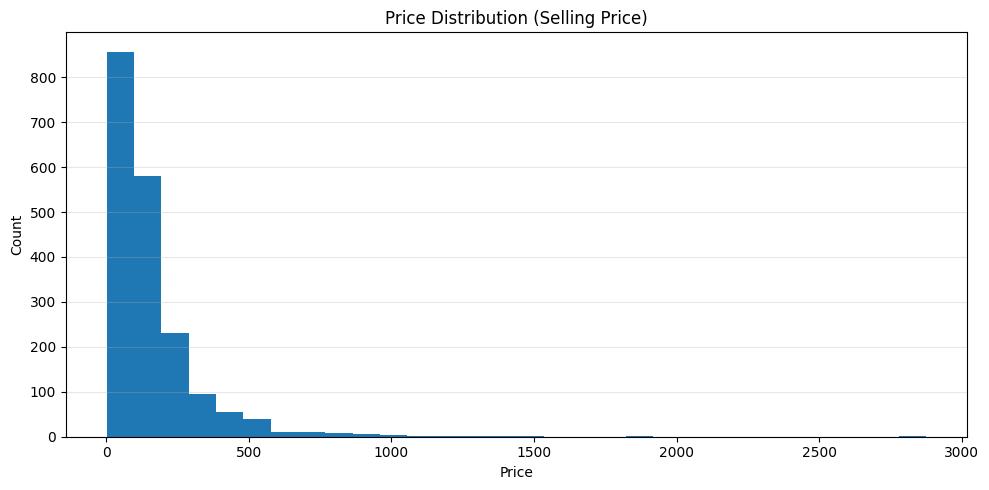

 Saved: C:\Users\Prath\outputs_furniture\charts\price_distribution.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\price_distribution.png'

In [11]:
# A) Price Distribution
plt.figure(figsize=(10, 5))
plt.hist(df["price"], bins=30)
plt.title("Price Distribution (Selling Price)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("price_distribution.png")

**Chart Purpose:
This chart visualizes the distribution of selling prices across furniture products.**

**Business Use:
Helps understand the pricing range of products and identify whether the catalog is dominated by low-cost or premium items.**

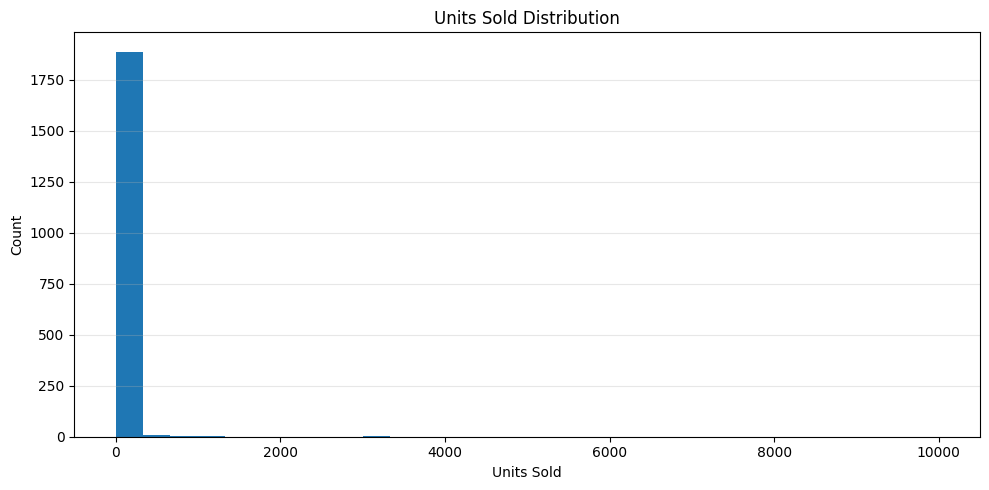

 Saved: C:\Users\Prath\outputs_furniture\charts\units_sold_distribution.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\units_sold_distribution.png'

In [12]:
# B) Units Sold Distribution
plt.figure(figsize=(10, 5))
plt.hist(df["sold"], bins=30)
plt.title("Units Sold Distribution")
plt.xlabel("Units Sold")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("units_sold_distribution.png")

**Chart Purpose:
This chart shows how units sold are distributed across products.**

**Business Use:
Helps identify demand concentration and whether most products sell in low or high volumes.**

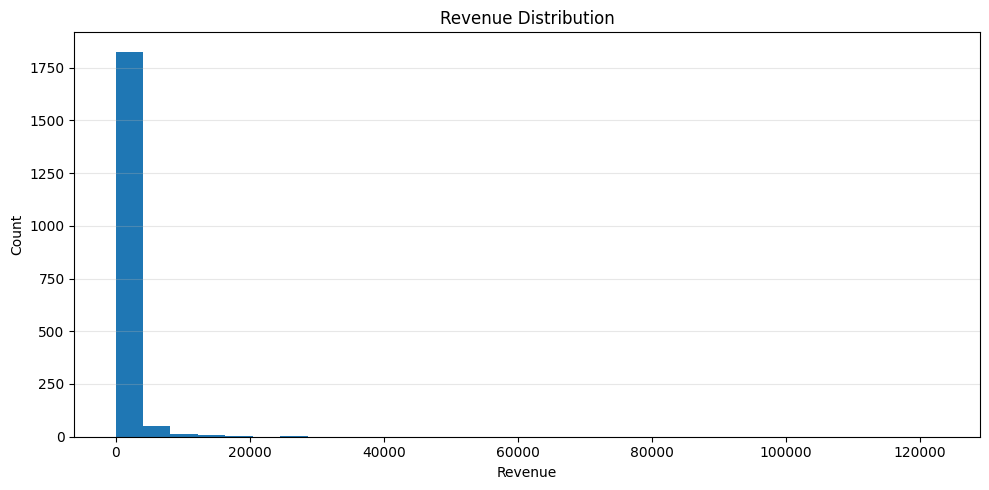

 Saved: C:\Users\Prath\outputs_furniture\charts\revenue_distribution.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\revenue_distribution.png'

In [13]:
# C) Revenue Distribution
plt.figure(figsize=(10, 5))
plt.hist(df["revenue"], bins=30)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("revenue_distribution.png")


**Chart Purpose:
This chart highlights how revenue is distributed across products.**

**Business Use:
Helps identify whether revenue is driven by a small number of high-performing products or evenly spread across the catalog.**

,product_title,Revenue,Units_Sold,Avg_Price
982,MUMUCC Multifunctional Foldable And Adjustable...,144150.00,6000,24.025
1329,Portable round Folding Chair Accordion Chair H...,122800.00,10000,12.280
400,Caterpillar Single Sofa Lazy Couch Tatami Livi...,101288.75,452,188.405
1112,"Monitor Stand for 13-32 inches Screens, Dual M...",60012.00,900,66.680
611,Electric Stand Up Desk Workstation Whole-Piece...,54055.80,354,152.700
980,MINGDIBAO Fabric Sofa Set Furniture Living Roo...,31853.75,25,1274.150
543,Dresser For Bedroom With 9 Fabric Drawers Ward...,28074.00,600,46.790
1569,Stylish Shoe Rack Metal Simple Shoe Shelf Foot...,27280.00,2000,13.640
1231,Office Furniture Computer Stand 42*26cm Adjust...,26030.00,1000,26.030
975,Luxury Living Room Sofa Furgle Chair Soft Sued...,19897.08,84,236.870


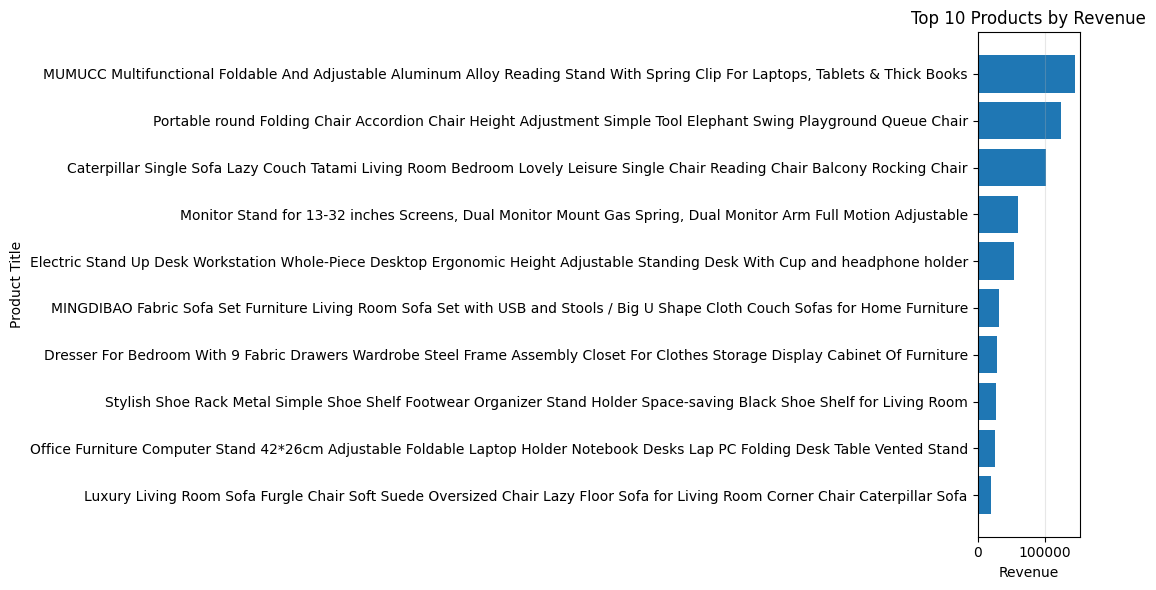

 Saved: C:\Users\Prath\outputs_furniture\charts\top10_products_by_revenue.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\top10_products_by_revenue.png'

In [15]:
# 1) Top 10 products by revenue (table)
top10_prod = (df.groupby("product_title", as_index=False)
              .agg(Revenue=("revenue", "sum"),
                   Units_Sold=("sold", "sum"),
                   Avg_Price=("price", "mean"))
              .sort_values("Revenue", ascending=False)
              .head(10))

display(top10_prod)

# (Optional) save table for PPT
top10_prod.to_csv(os.path.join(TABLES_DIR, "top10_products_by_revenue.csv"), index=False, encoding="utf-8-sig")

# 2) Horizontal bar chart (diagram)
plt.figure(figsize=(11, 6))
plt.barh(top10_prod["product_title"][::-1], top10_prod["Revenue"][::-1])
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product Title")
plt.grid(True, axis="x", alpha=0.3)

# show + save
save_and_show("top10_products_by_revenue.png")

**Chart Purpose:
This chart identifies the top 10 products contributing the highest revenue.**

**Business Use:
Supports prioritization of best-selling products for promotions, recommendations, and inventory planning.**

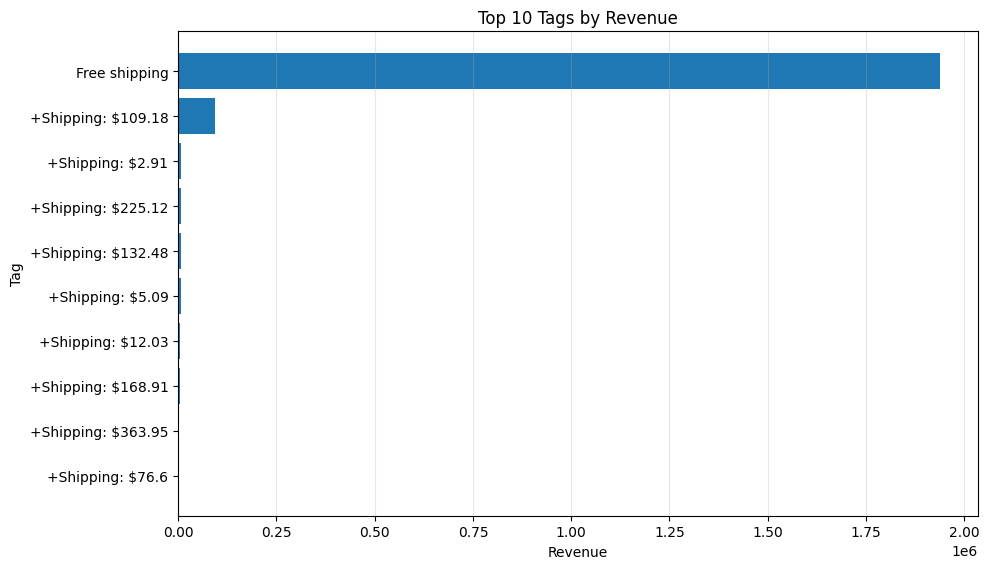

 Saved: C:\Users\Prath\outputs_furniture\charts\top10_tags_by_revenue.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\top10_tags_by_revenue.png'

In [16]:
# F) Tag-wise Performance (Revenue + Units)
tag_perf = (df.groupby("tag_text", as_index=False)
            .agg(Revenue=("revenue", "sum"),
                 Units_Sold=("sold", "sum"),
                 Avg_Price=("price", "mean"),
                 Avg_Discount=("discount_pct", "mean"),
                 Products=("product_title", "nunique"))
            .sort_values("Revenue", ascending=False))

export_csv(tag_perf, "tag_performance_all")

top10_tags = tag_perf.head(10)

plt.figure(figsize=(10, 5.8))
plt.barh(top10_tags["tag_text"][::-1], top10_tags["Revenue"][::-1])
plt.title("Top 10 Tags by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Tag")
plt.grid(True, axis="x", alpha=0.3)
save_and_show("top10_tags_by_revenue.png")



**Chart Purpose:
This chart compares revenue generated by different product tags.**

**Business Use:
Helps understand which furniture styles or themes perform best and guides marketing and product categorization strategies.**

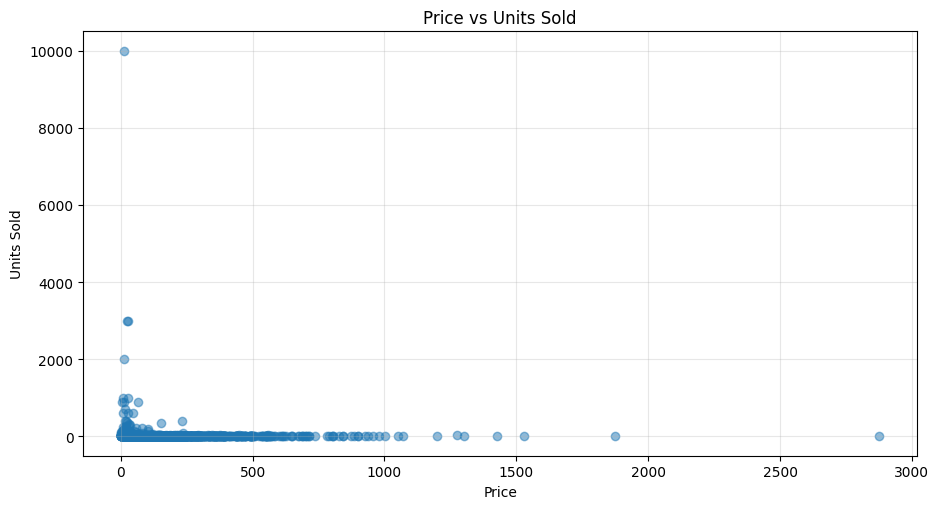

 Saved: C:\Users\Prath\outputs_furniture\charts\price_vs_units_sold.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\price_vs_units_sold.png'

In [17]:
# G) Price vs Units Sold (Scatter)
plt.figure(figsize=(9.5, 5.2))
plt.scatter(df["price"], df["sold"], alpha=0.5)
plt.title("Price vs Units Sold")
plt.xlabel("Price")
plt.ylabel("Units Sold")
plt.grid(True, alpha=0.3)
save_and_show("price_vs_units_sold.png")


**Chart Purpose:
This scatter plot analyzes the relationship between product price and units sold.**

**Business Use:
Helps assess price sensitivity and understand whether lower-priced products sell more units than higher-priced ones.**

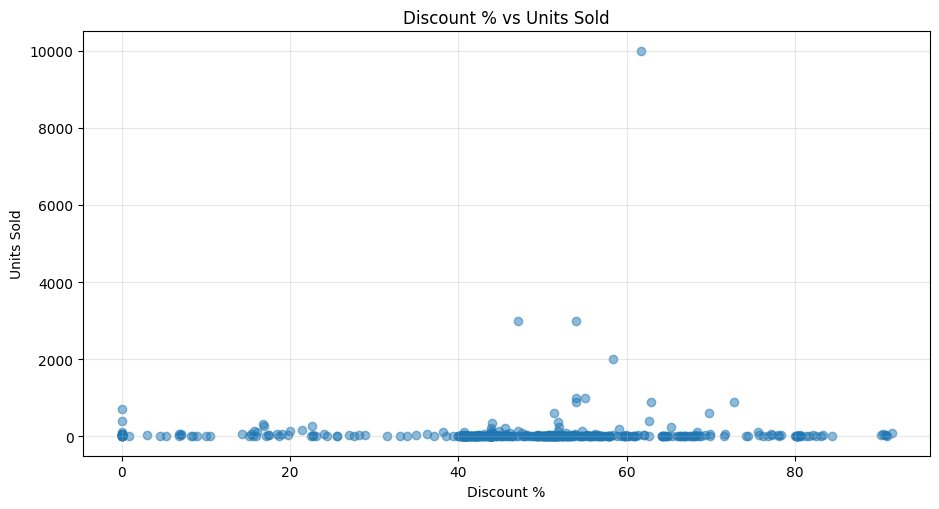

 Saved: C:\Users\Prath\outputs_furniture\charts\discount_pct_vs_units_sold.png


In [18]:
# H) Discount % vs Units Sold (only where discount exists)
disc_df = df[df["discount_pct"].notna() & (df["discount_pct"] >= 0)].copy()
if len(disc_df) >= 20:
    plt.figure(figsize=(9.5, 5.2))
    plt.scatter(disc_df["discount_pct"], disc_df["sold"], alpha=0.5)
    plt.title("Discount % vs Units Sold")
    plt.xlabel("Discount %")
    plt.ylabel("Units Sold")
    plt.grid(True, alpha=0.3)
    save_and_show("discount_pct_vs_units_sold.png")
else:
    print(" Not enough discount rows to plot Discount% vs Units Sold (need ~20+ rows).")


**Chart Purpose:
This chart analyzes how discount percentage affects units sold.**

**Business Use:
Supports optimization of discount strategies by understanding whether higher discounts lead to increased sales volume.**

,Products_for_80%_Revenue,Total_Products,%Products_for_80%_Revenue
0,318,1793,17.735639


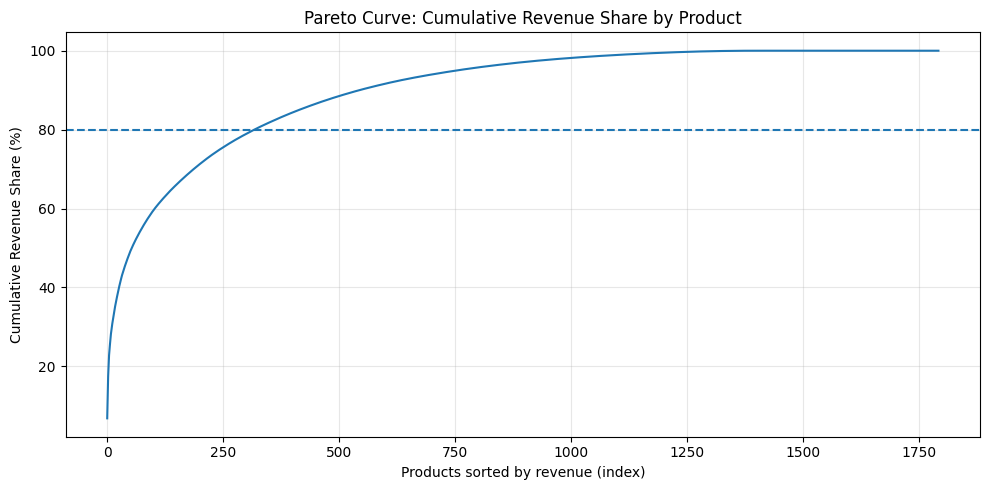

 Saved: C:\Users\Prath\outputs_furniture\charts\pareto_curve_products.png


'C:\\Users\\Prath\\outputs_furniture\\charts\\pareto_curve_products.png'

In [19]:
prod_rev = (df.groupby("product_title")["revenue"].sum()
            .sort_values(ascending=False)
            .reset_index(name="Revenue"))

prod_rev["Revenue_Share_%"] = 100 * prod_rev["Revenue"] / prod_rev["Revenue"].sum()
prod_rev["Cumulative_%"] = prod_rev["Revenue_Share_%"].cumsum()

export_csv(prod_rev, "pareto_products_revenue")

products_for_80 = int((prod_rev["Cumulative_%"] <= 80).sum())
pareto_summary = pd.DataFrame([{
    "Products_for_80%_Revenue": products_for_80,
    "Total_Products": int(prod_rev.shape[0]),
    "%Products_for_80%_Revenue": 100 * products_for_80 / max(1, int(prod_rev.shape[0]))
}])

export_csv(pareto_summary, "pareto_summary_80_20")
display(pareto_summary)

plt.figure(figsize=(10, 5))
plt.plot(prod_rev["Cumulative_%"].values)
plt.axhline(80, linestyle="--")
plt.title("Pareto Curve: Cumulative Revenue Share by Product")
plt.xlabel("Products sorted by revenue (index)")
plt.ylabel("Cumulative Revenue Share (%)")
plt.grid(True, alpha=0.3)
save_and_show("pareto_curve_products.png")


**Chart Purpose:
This analysis checks whether a small percentage of products contributes to a large portion of total revenue.**

**Business Use:
Helps focus resources on high-impact products that drive most of the revenue.**

### **Business Use & Impact**

**The insights from this analysis can help:**

**Optimize inventory and stock planning**

**Improve pricing and discount strategies**

**Focus marketing efforts on high-revenue products**

**Enhance product tagging and categorization**

**Support data-driven growth strategies in online furniture retail**

## **Conclusion**

**This project analyzed e-commerce furniture sales data to understand pricing behavior, product performance, and revenue distribution. 
Through data cleaning, KPI reporting, exploratory analysis, and advanced techniques such as Pareto analysis, actionable business insights 
were derived.**
**The analysis reveals that a small number of products and tags drive the majority of revenue, while pricing and discounts play a significant role in sales performance. These findings can support better inventory management, pricing optimization, and strategic decision-making in e-commerce furniture retail. Overall, the project demonstrates a complete data analyst workflow with strong business relevance.**